In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
airportdata = pd.read_csv('airports.csv', usecols=[0,1,2,3,4,5,6,7], names=['AirportID','Name','City','Country','IATA','ICAO','Latitude','Longitude'])
airportdata.head()

,AirportID,Name,City,Country,IATA,ICAO,Latitude,Longitude
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001


In [3]:
filePath = 'data/sample_data_DXB.csv'
data = pd.read_csv(filePath)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 716049 entries, 0 to 716048
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   airsenseMissionId  716049 non-null  int64  
 1   targetAddress      716049 non-null  int64  
 2   lat                716049 non-null  float64
 3   lon                716049 non-null  float64
 4   alt                716049 non-null  float64
 5   posTime            716049 non-null  int64  
 6   track              665601 non-null  float64
 7   speed              665601 non-null  float64
 8   targetId           713572 non-null  object 
 9   aircraftType       711939 non-null  object 
 10  aircraftReg        711585 non-null  object 
 11  airlineId          709429 non-null  object 
 12  touchdownPosTime   716049 non-null  int64  
 13  takeoffPosTime     716049 non-null  int64  
 14  destination        716049 non-null  object 
 15  origin             716049 non-null  object 
dtypes:

In [4]:
airport_names = pd.unique(data.origin)
airport_names = airport_names.tolist()
airport_names.append('DXB')

In [5]:
locations_own = {}
locations_unknown = {}
for airport_iata in airport_names:
    loc = airportdata.loc[airportdata['IATA']==airport_iata]
    if len(loc)>0:
        locations_own[airport_iata] = [float(loc['Latitude']), float(loc['Longitude'])]
    else:
        locations_unknown[airport_iata] = []

In [6]:
locations_unknown

{'GRV': [], 'NMF': [], 'GSM': [], 'BYB': []}

In [7]:
locations_unknown['GRV'] = [43.38489122958333, 45.700649360330836]
locations_unknown['NMF'] = [5.825289730090683, 73.47753787121358]
locations_unknown['GSM'] = [26.755950801249845, 55.89552228558024]
locations_unknown['BYB'] = [25.614667704625447, 56.24596821808005]

In [8]:
locations_own.update(locations_unknown)

In [9]:
def haversine(lat1, lon1, lat2, lon2, to_radians=True, earth_radius=6371):

    if to_radians:
        lat1, lon1, lat2, lon2 = np.deg2rad([lat1, lon1, lat2, lon2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return earth_radius * 2 * np.arcsin(np.sqrt(a))

def dist_per_flight(mID, df):
    locs = df.loc[df['airsenseMissionId']==mID, ['lat', 'lon', 'origin', 'destination', 'posTime', 'touchdownPosTime', 'takeoffPosTime']].dropna().sort_values('posTime')
    assert len(locs['touchdownPosTime'].unique()) == 1
    org_dest = locs.iloc[0]
    orig_name = str(org_dest.origin)
    dest_name = str(org_dest.destination)
    dest = pd.DataFrame({'lat':[locations_own[dest_name][0]], 'lon':[locations_own[dest_name][1]]})
    orig = pd.DataFrame({'lat':[locations_own[orig_name][0]], 'lon':[locations_own[orig_name][1]]})
    locs = pd.concat([orig, locs[['lat', 'lon']], dest],ignore_index=True)
    dist = np.nansum(haversine(locs.lat, locs.lon, locs.lat.shift(-1), locs.lon.shift(-1)))
    return dist, orig_name, dest_name

2475


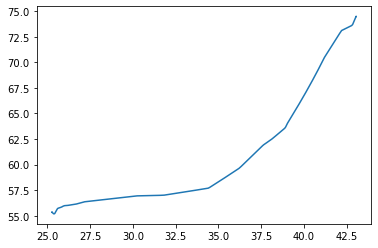

In [10]:
unique_missions = data['airsenseMissionId'].unique()
print(len(unique_missions))
test = data.loc[data['airsenseMissionId']==-6616577058941016649]
test_sorted = test.sort_values('posTime')
plt.plot(test_sorted.lat, test_sorted.lon)

In [11]:
unique_missions = data['airsenseMissionId'].unique()
distances = []
mission_ids = []
origins = []
destinations = []
for mission_ID in unique_missions:
    dist, orig, dest = dist_per_flight(mission_ID, data)
    distances.append(dist)
    mission_ids.append(mission_ID)
    origins.append(orig)
    destinations.append(dest)
    
new_df = pd.DataFrame({'origin': origins, 'destination':destinations, 'distance':distances})

(array([ 10.,  22.,  38.,  82.,   8.,  32.,  66.,  34.,  39.,  19.,   6.,
         40., 125.,  60., 104., 146.,  74.,  64.,  96.,  95., 148.,  69.,
         56.,  29.,  63.,  73.,  65.,  12.,  38.,  16.,  16.,  12.,  17.,
         31.,  58.,  31.,  60.,  40.,  56.,  44.,  33.,  14.,  16.,  35.,
         34.,  21.,  20.,   2.,   3.,  36.,   7.,   6.,   1.,   0.,   3.,
          1.,   2.,  10.,   0.,   2.,  11.,   2.,   0.,   0.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          4.,   8.,   6.,   3.,  10.,   8.,   4.,   8.,   6.,   4.,   8.,
          8.,   5.,   7.,   5.,   1.,   3.,   1.,   7.,   1.,   6.,   3.,
          2.]),
 array([   98.55099949,   242.32509108,   386.09918268,   529.87327427,
          673.64736586,   817.42145746,   961.19554905,  1104.96964065,
         1248.74373224,  1392.51782384,  1536.29191543,  1680.06600703,
         1823.84009862,  1967.61419022,  2111.38828181,  2255.16237341,
         2398.936465  ,  2542.

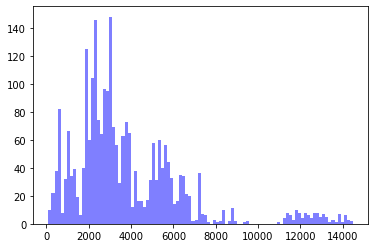

In [12]:
plt.hist(distances, 100, facecolor='blue', alpha=0.5)

In [13]:
data.destination.unique()

array(['DXB'], dtype=object)

In [14]:
new_df['origin'].value_counts()

DEL    99
BOM    93
BAH    68
CAI    54
DAC    53
       ..
HRG     1
STN     1
KZN     1
SZX     1
LYS     1
Name: origin, Length: 202, dtype: int64

In [15]:
max_flights_df = new_df.loc[new_df['origin']=='DEL']

In [16]:
print(max_flights_df.mean())
print(max_flights_df.var())

distance    2342.838781
dtype: float64
distance    1818.606981
dtype: float64


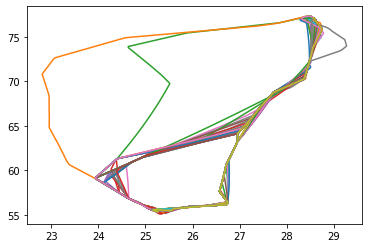

In [18]:
del_data = data.loc[data['origin']=='DEL']
del_ids = del_data['airsenseMissionId'].unique()
for mission_id in del_ids:
    test = del_data.loc[del_data['airsenseMissionId']==mission_id]
    test_sorted = test.sort_values('posTime')
    plt.plot(test_sorted.lat, test_sorted.lon)